# Libraries used in the project


In [977]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold



import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Input, LSTM, Dense,LeakyReLU,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.activations import tanh, linear


In [978]:
df=pd.read_csv('final_data.csv')

In [979]:
df.head()

,Date,Customer_Name,Item_Name,Vrh_No,Quantity,Price_per_unit,Amount
0,2019-01-04,customer1,Item_1,1,200,20,4000
1,2019-01-04,customer7,Item_3,10,15,33,495
2,2019-01-04,customer7,Item_1,10,50,20,1000
3,2019-01-04,customer8,Item_11,11,80,30,2400
4,2019-01-04,customer8,Item_7,11,624,21,13416


In [980]:
df.shape

(1957, 7)

In [981]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            1957 non-null   object
 1   Customer_Name   1957 non-null   object
 2   Item_Name       1957 non-null   object
 3   Vrh_No          1957 non-null   int64 
 4   Quantity        1957 non-null   int64 
 5   Price_per_unit  1957 non-null   int64 
 6   Amount          1957 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 107.1+ KB


In [982]:
df.Date=pd.to_datetime(df.Date,infer_datetime_format=True)

In [983]:
def sales_duration(data):
  
    number_of_days = data.Date.max() - data.Date.min()
    print(data.Date.max())
    print(data.Date.min())

    print(number_of_days.days, 'days')
    
sales_duration(df)

2021-12-01 00:00:00
2019-01-04 00:00:00
1062 days


In [984]:
# this function resample our data to 36 rows(months)

def monthly_data_generator(data):
    
    monthly_resample_amount=data.copy()
    monthly_resample_amount.set_index("Date", inplace = True)
    monthly_resample_amount = monthly_resample_amount['Amount'].resample('M').sum() 
    value=monthly_resample_amount.median()
    monthly_resample_amount['2021-10-31']=value
    
    monthly_resample_quantity=data.copy()
    monthly_resample_quantity.set_index("Date", inplace = True)
    monthly_resample_quantity = monthly_resample_quantity['Quantity'].resample('M').sum() 
    value=monthly_resample_quantity.median()
    monthly_resample_quantity['2021-10-31']=value

    data_monthly=pd.DataFrame()
    
    data_monthly['Amount']=monthly_resample_amount
    data_monthly['Quantity']=monthly_resample_quantity
    
    data_monthly['Price_per_unit']=data_monthly['Amount']/ data_monthly['Quantity']
    
    return data_monthly

In [986]:
data=monthly_data_generator(df)
data['Date']=data.index

In [987]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-01-31 to 2021-12-31
Freq: M
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Amount          36 non-null     float64       
 1   Quantity        36 non-null     int64         
 2   Price_per_unit  36 non-null     float64       
 3   Date            36 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 2.5 KB


In [988]:
data

,Amount,Quantity,Price_per_unit,Date
Date,,,,
2019-01-31,452115.0,14884,30.375907,2019-01-31
2019-02-28,382244.0,19757,19.347269,2019-02-28
2019-03-31,79462.0,4037,19.683428,2019-03-31
2019-04-30,1194383.0,50709,23.553669,2019-04-30
2019-05-31,1102652.0,42736,25.801479,2019-05-31
2019-06-30,898811.0,32924,27.299569,2019-06-30
2019-07-31,672657.0,28469,23.627700,2019-07-31
2019-08-31,313239.0,11287,27.752193,2019-08-31
2019-09-30,379865.0,16176,23.483247,2019-09-30


<AxesSubplot:xlabel='Date'>

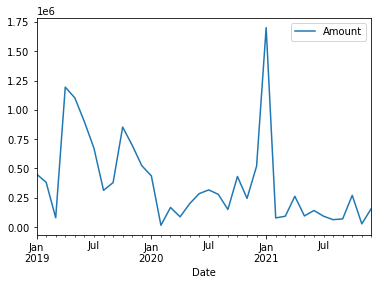

In [989]:
data.set_index(data.index)[['Amount']].plot()


<AxesSubplot:xlabel='Date'>

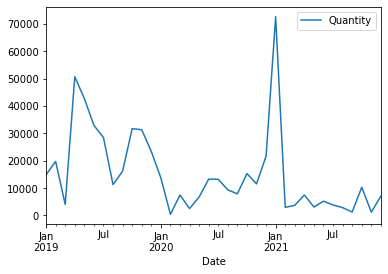

In [990]:
data.set_index(data.index)[['Quantity']].plot()


<AxesSubplot:xlabel='Date'>

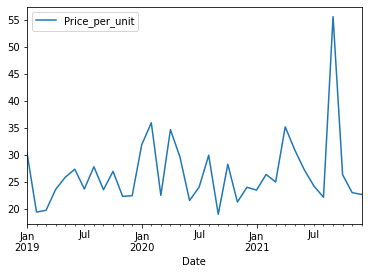

In [991]:
data.set_index(data.index)[['Price_per_unit']].plot()


In [992]:
data.describe()

,Amount,Quantity,Price_per_unit
count,3.600000e+01,36.000000,36.000000
mean,3.816097e+05,15337.944444,26.558047
std,3.757225e+05,15665.402538,6.608035
min,1.490300e+04,415.000000,18.932332
25%,9.430800e+04,3984.750000,22.576234
50%,2.750448e+05,10801.000000,24.556036
75%,4.689658e+05,20240.250000,28.544141
max,1.702176e+06,72672.000000,55.595219


# Regression Modeling for Sales Predictions

In [993]:
# create dataframe with lag features
def lagging_feature(df):
    df1=pd.DataFrame()
    df1['Amount']=df['Amount']
    df1['1_month_back']=df['Amount'].shift(+1)
    df1['2_month_back']=df['Amount'].shift(+2)
    df1['3_Amount_Last']=df['Amount'].shift(+3)
    df1['4_Amount_Last']=df['Amount'].shift(+4)
    df1['5_Amount_Last']=df['Amount'].shift(+5)
    df1['Quantity']=df['Quantity']
    df1=df1.iloc[5:,:]
    
    return df1

In [995]:
#apply Min Max Scaler/Standard scaler
def scale_data(df2):
   
     
    scaler = MinMaxScaler()
    scaler = scaler.fit(df2)
    df2=scaler.fit_transform(df2)

    
    return df2, scaler

In [996]:
# train test splittng 

def train_test_splitting(df3):    
    
    X_train,X_test,y_train,y_test=train_test_split(df3.iloc[:,1:],df3.iloc[:,0],
                                  test_size=0.20,random_state=123,shuffle=False)
    
    return X_train,X_test,y_train,y_test

In [898]:
# funct

model_scores = {}

def get_scores(pred, original_value, model_name):
    rmse = np.sqrt(mean_squared_error(original_value,pred))
    mae = mean_absolute_error(original_value,pred)
    r2 = r2_score(original_value,pred)
    n=28
    p=6
    adj_r2 = 1-(((1-r2)*(n-1))/(n-p-1))
    model_scores[model_name] = [rmse, mae, r2,adj_r2]
    

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    print(f"Adj_R2 Score: {adj_r2}")

In [ ]:
def undo_scaling(pred,original_value, scaler_obj): 

    pred=scaler_obj.inverse_transform(pred.reshape(1, -1))
    original_value=scaler_obj.inverse_transform(original_value.reshape(1, -1))

    
    return pred,original_value

In [900]:
def plot_results(pred, original_value, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(data.index[29:],original_value,
                 label='Original', color='mediumblue')
    sns.lineplot(data.index[29:],pred,
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Amount",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
   

In [901]:
def run_model(df1, model, model_name):
    
    lag_data=lagging_feature(data)
    
    scaled_data, scaler_object = scale_data(lag_data)
    
    X_train,X_test,y_train,y_test=train_test_splitting(lag_data)
    
    model = model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #predictions,y_test=undo_scaling(predictions,y_test,scaler_object)
    get_scores(predictions, y_test, model_name)
    
    plot_results(predictions, y_test, model_name)

RMSE: 24744.73312024259
MAE: 21088.395381181934
R2 Score: 0.8922624595446755
Adj_R2 Score: 0.8614803051288685


C:\Users\Kuldeep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Kuldeep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


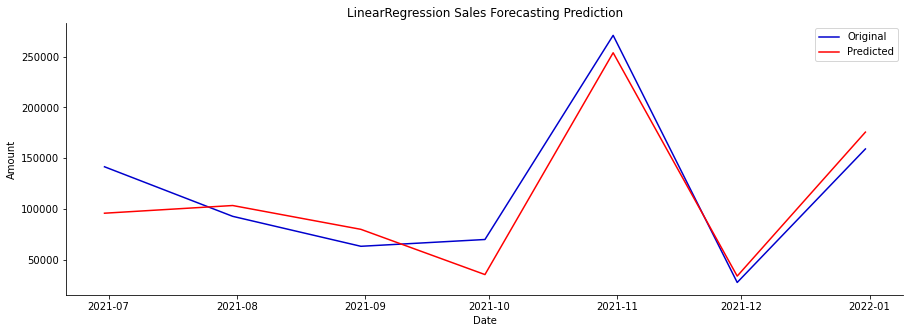

In [902]:
run_model(data,LinearRegression(),'LinearRegression')


RMSE: 40577.19965251264
MAE: 33644.44142857143
R2 Score: 0.7102885550893632
Adj_R2 Score: 0.6275138565434669


C:\Users\Kuldeep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Kuldeep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


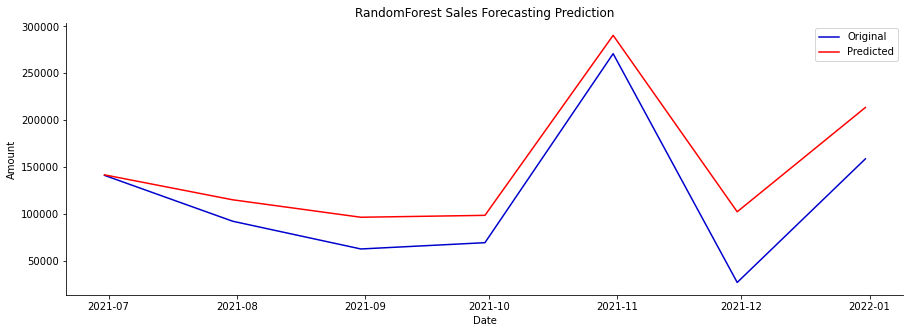

In [903]:
run_model(data,RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

RMSE: 27587.71640153315
MAE: 21421.262276785714
R2 Score: 0.8660838318090527
Adj_R2 Score: 0.827822069468782


C:\Users\Kuldeep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Kuldeep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


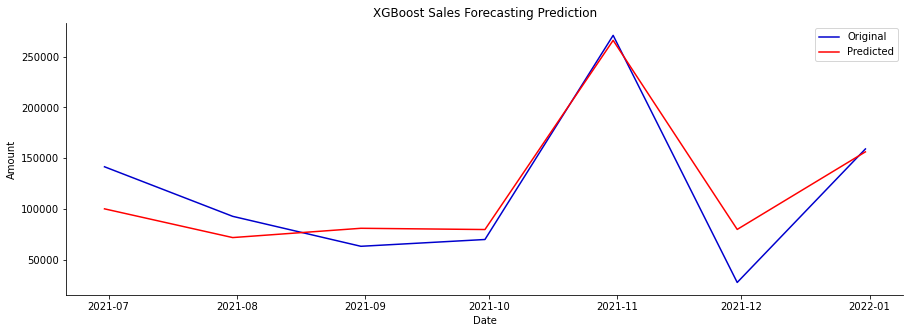

In [904]:
run_model(data, XGBRegressor( n_estimators=500, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [905]:
pd.DataFrame(model_scores,index=['RSME','MAE','R2','Adj_R'])

,LinearRegression,RandomForest,XGBoost
RSME,24744.733120,40577.199653,27587.716402
MAE,21088.395381,33644.441429,21421.262277
R2,0.892262,0.710289,0.866084
Adj_R,0.861480,0.627514,0.827822


In [922]:
def demand_lagging_feature(df):
    df1=pd.DataFrame()
    df1['Quantity']=df['Quantity']
    df1['1_month_back']=df['Quantity'].shift(+1)
    df1['2_month_back']=df['Quantity'].shift(+2)
    df1['3_Amount_Last']=df['Quantity'].shift(+3)
    df1['4_Amount_Last']=df['Quantity'].shift(+4)
    df1['5_Amount_Last']=df['Quantity'].shift(+5)
    df1['6_Amount_Last']=df['Quantity'].shift(+6)

    df1=df1.iloc[6:,:]
    
    return df1

In [924]:
demand_lagging_feature(data)

,Quantity,1_month_back,2_month_back,3_Amount_Last,4_Amount_Last,5_Amount_Last,6_Amount_Last
Date,,,,,,,
2019-07-31,28469,32924.0,42736.0,50709.0,4037.0,19757.0,14884.0
2019-08-31,11287,28469.0,32924.0,42736.0,50709.0,4037.0,19757.0
2019-09-30,16176,11287.0,28469.0,32924.0,42736.0,50709.0,4037.0
2019-10-31,31725,16176.0,11287.0,28469.0,32924.0,42736.0,50709.0
2019-11-30,31337,31725.0,16176.0,11287.0,28469.0,32924.0,42736.0
2019-12-31,23410,31337.0,31725.0,16176.0,11287.0,28469.0,32924.0
2020-01-31,13716,23410.0,31337.0,31725.0,16176.0,11287.0,28469.0
2020-02-29,415,13716.0,23410.0,31337.0,31725.0,16176.0,11287.0
2020-03-31,7462,415.0,13716.0,23410.0,31337.0,31725.0,16176.0


In [925]:
demand_model_scores = {}

def demand_get_scores(pred, original_value, model_name):
    rmse = np.sqrt(mean_squared_error(original_value,pred))
    mae = mean_absolute_error(original_value,pred)
    r2 = r2_score(original_value,pred)
    n=28
    p=6
    adj_r2 = 1-(((1-r2)*(n-1))/(n-p-1))
    demand_model_scores[model_name] = [rmse, mae, r2,adj_r2]
    

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    print(f"Adj_R2 Score: {adj_r2}")

In [926]:
lag_data=demand_lagging_feature(data)
    
#scaled_data, scaler_object = scale_data(lag_data)
    
X_train,X_test,y_train,y_test=train_test_splitting(lag_data)
X_train

,1_month_back,2_month_back,3_Amount_Last,4_Amount_Last,5_Amount_Last,6_Amount_Last
Date,,,,,,
2019-07-31,32924.0,42736.0,50709.0,4037.0,19757.0,14884.0
2019-08-31,28469.0,32924.0,42736.0,50709.0,4037.0,19757.0
2019-09-30,11287.0,28469.0,32924.0,42736.0,50709.0,4037.0
2019-10-31,16176.0,11287.0,28469.0,32924.0,42736.0,50709.0
2019-11-30,31725.0,16176.0,11287.0,28469.0,32924.0,42736.0
2019-12-31,31337.0,31725.0,16176.0,11287.0,28469.0,32924.0
2020-01-31,23410.0,31337.0,31725.0,16176.0,11287.0,28469.0
2020-02-29,13716.0,23410.0,31337.0,31725.0,16176.0,11287.0
2020-03-31,415.0,13716.0,23410.0,31337.0,31725.0,16176.0


In [929]:
def demand_run_model(df1, model, model_name):
    
    lag_data=demand_lagging_feature(data)
    
    scaled_data, scaler_object = scale_data(lag_data)
    
    X_train,X_test,y_train,y_test=train_test_splitting(lag_data)
    
    model = model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #predictions,y_test=undo_scaling(predictions,y_test,scaler_object)
    demand_get_scores(predictions, y_test, model_name)
    
  #  plot_results(predictions, y_test, model_name)

In [930]:
demand_run_model(data,LinearRegression(),'LinearRegression')


RMSE: 13895.540033432617
MAE: 10916.688370581254
R2 Score: -16.888752475702013
Adj_R2 Score: -21.999824611616873


In [933]:
demand_run_model(data,RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

RMSE: 10678.552096887168
MAE: 9978.886666666667
R2 Score: -9.564621370452143
Adj_R2 Score: -12.583084619152755


In [932]:
demand_run_model(data, XGBRegressor( n_estimators=500, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

RMSE: 7935.608455734571
MAE: 7002.342447916667
R2 Score: -4.8343121107869385
Adj_R2 Score: -6.501258428154635


# LSTM Model Building

In [259]:
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(data)

In [260]:
data_scaled[:3]

array([[0.25912345, 0.20024358, 0.31212968],
       [0.21771284, 0.26768341, 0.01131765],
       [0.03826233, 0.05012663, 0.02048656]])

In [261]:
feature=data_scaled
target=data_scaled[:,0]

In [262]:
TimeseriesGenerator(feature,target,length=2,sampling_rate=1,batch_size=1)[0]

(array([[[0.25912345, 0.20024358, 0.31212968],
         [0.21771284, 0.26768341, 0.01131765]]]),
 array([0.03826233]))

In [263]:
X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.20,random_state=123,shuffle=False)

In [264]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(28, 3) (8, 3) (28,) (8,)


In [265]:
train_generator=TimeseriesGenerator(X_train,y_train,length=2,sampling_rate=1,batch_size=1)
test_generator=TimeseriesGenerator(X_test,y_test,length=2,sampling_rate=1,batch_size=1)

In [266]:
train_generator[0]

(array([[[0.25912345, 0.20024358, 0.31212968],
         [0.21771284, 0.26768341, 0.01131765]]]),
 array([0.03826233]))

In [267]:
test_generator[0]

(array([[[0.04739956, 0.0367992 , 0.32546986],
         [0.07498075, 0.06629116, 0.22466666]]]),
 array([0.0460459]))

In [378]:
model = Sequential()
model.add(LSTM(128, input_shape=(2,3),return_sequences=True))


model.add(LSTM(64,return_sequences=True))
model.add(Activation('tanh'))
model.add(Dropout(0.3))


model.add(LSTM(32,return_sequences=True))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

model.add(LSTM(16,return_sequences=False))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

model.add(Dense(1))
model.add(Activation('linear'))

In [379]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 2, 128)            67584     
                                                                 
 lstm_75 (LSTM)              (None, 2, 64)             49408     
                                                                 
 activation_16 (Activation)  (None, 2, 64)             0         
                                                                 
 dropout_49 (Dropout)        (None, 2, 64)             0         
                                                                 
 lstm_76 (LSTM)              (None, 2, 32)             12416     
                                                                 
 activation_17 (Activation)  (None, 2, 32)             0         
                                                                 
 dropout_50 (Dropout)        (None, 2, 32)           

In [380]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

model.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.losses.MeanAbsoluteError()])


history=model.fit(train_generator,epochs=50,
                  validation_data=test_generator,
                 shuffle=False,
                 callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 33s 237ms/step - loss: 0.1116 - mean_absolute_error: 0.2347 - val_loss: 0.0028 - val_mean_absolute_error: 0.0475
Epoch 2/50
26/26 [==============================] - 1s 22ms/step - loss: 0.0841 - mean_absolute_error: 0.2022 - val_loss: 0.0183 - val_mean_absolute_error: 0.1249
Epoch 3/50
26/26 [==============================] - 1s 25ms/step - loss: 0.0662 - mean_absolute_error: 0.1845 - val_loss: 0.0241 - val_mean_absolute_error: 0.1466
Epoch 4/50
26/26 [==============================] - 1s 25ms/step - loss: 0.0673 - mean_absolute_error: 0.1910 - val_loss: 0.0227 - val_mean_absolute_error: 0.1426
Epoch 5/50
26/26 [==============================] - 1s 26ms/step - loss: 0.0600 - mean_absolute_error: 0.1697 - val_loss: 0.0250 - val_mean_absolute_error: 0.1505
Epoch 6/50
26/26 [==============================] - 1s 36ms/step - loss: 0.0677 - mean_absolute_error: 0.1897 - val_loss: 0.0283 - val_mean_absolute_error: 0.1614
Epoch 7/50
26/26 [==

In [381]:
# make predictions on the test data
prediction = model.predict(test_generator)


6/6 [==============================] - 11s 7ms/step


In [382]:
prediction

array([[ 0.13297878],
       [ 0.19553474],
       [ 0.24467432],
       [ 0.15926602],
       [-0.13091895],
       [ 0.21498224]], dtype=float32)

In [383]:
y_test


array([0.04739956, 0.07498075, 0.0460459 , 0.02855436, 0.03251934,
       0.15171019, 0.00744634, 0.08539045])

In [384]:
X_test

array([[0.04739956, 0.0367992 , 0.32546986],
       [0.07498075, 0.06629116, 0.22466666],
       [0.0460459 , 0.04723418, 0.14337495],
       [0.02855436, 0.03376835, 0.08627088],
       [0.03251934, 0.01162517, 1.        ],
       [0.15171019, 0.13701095, 0.19988619],
       [0.00744634, 0.01082248, 0.1094895 ],
       [0.08539045, 0.09153438, 0.10052113]])

In [385]:
X_test[:,1:][2:]

array([[0.04723418, 0.14337495],
       [0.03376835, 0.08627088],
       [0.01162517, 1.        ],
       [0.13701095, 0.19988619],
       [0.01082248, 0.1094895 ],
       [0.09153438, 0.10052113]])

In [386]:
df_pred=pd.concat([pd.DataFrame(prediction),pd.DataFrame(X_test[:,1:][2:])],axis=1)

In [387]:
df_pred

,0,0,1
0,0.132979,0.047234,0.143375
1,0.195535,0.033768,0.086271
2,0.244674,0.011625,1.000000
3,0.159266,0.137011,0.199886
4,-0.130919,0.010822,0.109490
5,0.214982,0.091534,0.100521


In [388]:
rev_trans=scaler.inverse_transform(df_pred)

In [389]:
rev_trans

array([[ 2.39274509e+05,  3.82800000e+03,  2.41888715e+01],
       [ 3.44823480e+05,  2.85500000e+03,  2.20952715e+01],
       [ 4.27735382e+05,  1.25500000e+03,  5.55952191e+01],
       [ 2.83628264e+05,  1.03150000e+04,  2.62607368e+01],
       [-2.05993009e+05,  1.19700000e+03,  2.29465330e+01],
       [ 3.77636731e+05,  7.02900000e+03,  2.26177266e+01]])

In [390]:
df_final=data[prediction.shape[0]*-1:]

In [391]:
df_final.count()

Amount            6
Quantity          6
Price_per_unit    6
dtype: int64

In [392]:
df_final['App_pred']=rev_trans[:,0]

C:\Users\Kuldeep\AppData\Local\Temp\ipykernel_6148\3779226330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['App_pred']=rev_trans[:,0]


In [393]:
df_final

,Amount,Quantity,Price_per_unit,App_pred
Date,,,,
2021-07-31,92595.0,3828,24.188871,239274.508539
2021-08-31,63082.0,2855,22.095271,344823.480477
2021-09-30,69772.0,1255,55.595219,427735.382348
2021-10-31,270879.5,10315,26.260737,283628.263510
2021-11-30,27467.0,1197,22.946533,-205993.009258
2021-12-31,158980.0,7029,22.617727,377636.731380


<AxesSubplot:xlabel='Date'>

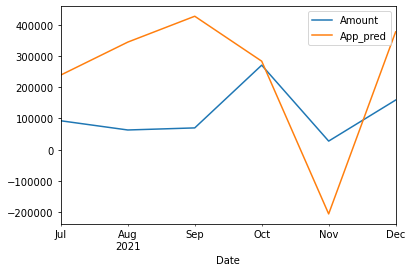

In [394]:
df_final[['Amount','App_pred']].plot()

In [396]:
mean_absolute_error(df_final['Amount'],df_final['App_pred'])

208541.64591846615

In [944]:
data1=pd.read_csv('111.csv')

In [949]:
data2=data1.iloc[:,1:4]

In [974]:
scaler.inverse_transform(scaled[-5:,:])

array([[6.30820000e+04, 2.85500000e+03, 2.20952715e+01],
       [6.97720000e+04, 1.25500000e+03, 5.55952191e+01],
       [2.70879500e+05, 1.03150000e+04, 2.62607368e+01],
       [2.74670000e+04, 1.19700000e+03, 2.29465330e+01],
       [1.58980000e+05, 7.02900000e+03, 2.26177266e+01]])

In [976]:
data2.tail()

,Amount,Quantity,Price_per_unit
31,63082.0,2855,22.095271
32,69772.0,1255,55.595219
33,270879.5,10315,26.260737
34,27467.0,1197,22.946533
35,158980.0,7029,22.617727


In [953]:
scaler=MinMaxScaler()

In [975]:
scaled=scaler.fit_transform(data2)
scaled[-5:,:]

array([[0.02855436, 0.03376835, 0.08627088],
       [0.03251934, 0.01162517, 1.        ],
       [0.15171019, 0.13701095, 0.19988619],
       [0.00744634, 0.01082248, 0.1094895 ],
       [0.08539045, 0.09153438, 0.10052113]])